# Notebook exploration données : metrics

Ce notebook génère 2 fichiers csv 

- complet avec les données métrics nettoyées et les colonnes json fractionnées,

- partiel avec les données métrics et ne conservant que les id des events.

## Imports

In [1]:
import os, json
import pandas as pd
import numpy as np

from azure_blob import download_blob_file
from preprocess_functions import convert_str_to_list, get_keys, add_key_column, convert_str_to_int_list

import matplotlib.pyplot as plt
from datetime import datetime

### Data

In [2]:
filename = 'metrics.csv'
path = '../data/'

In [3]:
# téléchargement dans le repertoire 'data' d'un fichiers 'csv' depuis le blob
download_blob_file(file_name=filename, local_path=path)
metrics = os.path.join(path, filename)

metrics.csv already in path ../data/.


In [4]:
# création d'un dataframe à partir du csv de données
metrics_df = pd.read_csv(metrics).sort_values(by='created_at')
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164430 entries, 307539 to 1164429
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1164430 non-null  int64  
 1   status                     1164430 non-null  object 
 2   created_at                 1164430 non-null  object 
 3   cyan_capacity              0 non-null        float64
 4   cyan_remaining             0 non-null        float64
 5   magenta_capacity           0 non-null        float64
 6   magenta_remaining          0 non-null        float64
 7   yellow_capacity            0 non-null        float64
 8   yellow_remaining           0 non-null        float64
 9   black_capacity             0 non-null        float64
 10  black_remaining            0 non-null        float64
 11  machineId                  1164430 non-null  int64  
 12  connected_operators        1164430 non-null  object 
 13  varnish

In [5]:
metrics_df.dropna(axis=1, inplace=True)
metrics_df.drop('machineId', axis=1, inplace=True)
# metrics_df.set_index('id')

In [6]:
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164430 entries, 307539 to 1164429
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1164430 non-null  int64  
 1   status                     1164430 non-null  object 
 2   created_at                 1164430 non-null  object 
 3   connected_operators        1164430 non-null  object 
 4   varnishLevelsTargetvolume  1164430 non-null  float64
 5   varnishLevelsTotalvolume   1164430 non-null  int64  
 6   modules                    1164430 non-null  object 
 7   events                     1164430 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 80.0+ MB


In [7]:
metrics_df.head(3)

,id,status,created_at,connected_operators,varnishLevelsTargetvolume,varnishLevelsTotalvolume,modules,events
307539,4169748,WARNING,2022-04-15 05:55:06.678000,"[{""name"": ""Viktor"", ""level"": ""Operator""}]",36192.322612,100000,"[{""sn"": """", ""name"": ""Print Engine 1"", ""type"": ...",[]
307540,4169749,WARNING,2022-04-15 05:55:06.829000,"[{""name"": ""Viktor"", ""level"": ""Operator""}]",36192.322612,100000,"[{""sn"": """", ""name"": ""Print Engine 1"", ""type"": ...","[{""source"": ""PLC"", ""message"": "" JV-Ti non prêt..."
307537,4169753,WARNING,2022-04-15 05:55:14.494000,"[{""name"": ""Viktor"", ""level"": ""Operator""}]",36192.322612,100000,"[{""sn"": """", ""name"": ""Print Engine 1"", ""type"": ...",[]


## Dataframes

### Column "connected_operators"

In [8]:
#metrics_df.connected_operators = metrics_df.connected_operators.apply(lambda x :json.loads(x)[0])
connected_operators_df = convert_str_to_list(metrics_df.connected_operators)

In [9]:
# on récupère les clés du dictionnaire dans la première ligne du dataset 'loc.[0]' dans la première case de la liste '[0]'
connected_operators_keys = get_keys(connected_operators_df.connected_operators.loc[0][0])

In [10]:
# on ajoute des colonnes pour chaque clés
for key in connected_operators_keys:
    connected_operators_df = add_key_column(connected_operators_df, 'connected_operators', connected_operators_keys,0)

In [11]:
# on supprime la colonne d'origine
connected_operators_df.drop('connected_operators', axis='columns', inplace=True)

In [12]:
connected_operators_df.rename(
    columns={
    'connected_operators_name_0': 'operators_name',
    'connected_operators_level_0': 'operators_level'
    }, 
    inplace=True)

In [13]:
connected_operators_df.head(3)

,operators_name,operators_level
307539,Viktor,Operator
307540,Viktor,Operator
307537,Viktor,Operator


### Column "modules"

In [14]:
modules_df = convert_str_to_list(metrics_df.modules)

In [15]:
modules_keys = get_keys(modules_df.modules.loc[0][0])

In [16]:
for key in modules_keys:
    modules_df = add_key_column(modules_df, 'modules', modules_keys,0)
for key in modules_keys:
    modules_df = add_key_column(modules_df, 'modules', modules_keys,1)

In [17]:
modules_df.head(3)

,modules,modules_sn_0,modules_name_0,modules_type_0,modules_counters_0,modules_generation_0,modules_sn_1,modules_name_1,modules_type_1,modules_counters_1,modules_generation_1
307539,"[{'sn': '', 'name': 'Print Engine 1', 'type': ...",,Print Engine 1,Varnish Printer,"[{'name': '3D Varnish Counter', 'value': 17929...",,,iFoil L,iFoil,"[{'name': 'Total Pages Counter', 'value': 2288...",Gen. 2
307540,"[{'sn': '', 'name': 'Print Engine 1', 'type': ...",,Print Engine 1,Varnish Printer,"[{'name': '3D Varnish Counter', 'value': 17929...",,,iFoil L,iFoil,"[{'name': 'Total Pages Counter', 'value': 2288...",Gen. 2
307537,"[{'sn': '', 'name': 'Print Engine 1', 'type': ...",,Print Engine 1,Varnish Printer,"[{'name': '3D Varnish Counter', 'value': 17929...",,,iFoil L,iFoil,"[{'name': 'Total Pages Counter', 'value': 2288...",Gen. 2


In [18]:
modules_df.drop('modules', axis='columns', inplace=True)

In [19]:
modules_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164430 entries, 307539 to 1164429
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   modules_sn_0          1164430 non-null  object
 1   modules_name_0        1164430 non-null  object
 2   modules_type_0        1164430 non-null  object
 3   modules_counters_0    1164430 non-null  object
 4   modules_generation_0  1164430 non-null  object
 5   modules_sn_1          1164430 non-null  object
 6   modules_name_1        1164430 non-null  object
 7   modules_type_1        1164430 non-null  object
 8   modules_counters_1    1164430 non-null  object
 9   modules_generation_1  1164430 non-null  object
dtypes: object(10)
memory usage: 130.0+ MB


#### Column "modules counters"

In [20]:
modules_counters_keys = get_keys(modules_df.modules_counters_0.loc[0][0])

In [21]:
for key in modules_counters_keys:
    modules_df = add_key_column(modules_df, 'modules_counters_0', modules_counters_keys,0)
for key in modules_counters_keys:
    modules_df = add_key_column(modules_df, 'modules_counters_1', modules_counters_keys,0)

In [22]:
modules_df.drop(['modules_counters_0', 'modules_counters_1'], axis='columns', inplace=True)

In [23]:
modules_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1164430 entries, 307539 to 1164429
Data columns (total 12 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   modules_sn_0                1164430 non-null  object
 1   modules_name_0              1164430 non-null  object
 2   modules_type_0              1164430 non-null  object
 3   modules_generation_0        1164430 non-null  object
 4   modules_sn_1                1164430 non-null  object
 5   modules_name_1              1164430 non-null  object
 6   modules_type_1              1164430 non-null  object
 7   modules_generation_1        1164430 non-null  object
 8   modules_counters_0_name_0   1164430 non-null  object
 9   modules_counters_0_value_0  1164430 non-null  int64 
 10  modules_counters_1_name_0   1164430 non-null  object
 11  modules_counters_1_value_0  1164430 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 147.7+ MB


In [24]:
modules_df.dropna(axis='columns', how='any', inplace=True)

In [25]:
for col in modules_df.columns :
    if modules_df[col].nunique() > 1 :
        print(col, 'nombre de valeurs unique : %d' % modules_df[col].nunique())
    else :
        print(col, modules_df[col].unique())

modules_sn_0 ['']
modules_name_0 ['Print Engine 1']
modules_type_0 ['Varnish Printer']
modules_generation_0 ['']
modules_sn_1 ['']
modules_name_1 ['iFoil L']
modules_type_1 ['iFoil']
modules_generation_1 ['Gen. 2']
modules_counters_0_name_0 ['3D Varnish Counter']
modules_counters_0_value_0 nombre de valeurs unique : 294500
modules_counters_1_name_0 ['Total Pages Counter']
modules_counters_1_value_0 nombre de valeurs unique : 65342


In [26]:
columns_to_drop = []
for col in modules_df.columns :
    if modules_df[col].nunique() == 1 :
        if modules_df[col].unique().item() != '':
            columns_to_drop.append(col)
        else :
            modules_df.drop(columns=[col], axis='columns', inplace=True)

In [27]:
modules_df.rename(columns={
    'modules_counters_0_value_0': 'VarnishPrinter_3DVarnishCounter',
    'modules_counters_1_value_0': 'iFoil_TotalPagesCounter'
    }, inplace=True)
modules_df.drop(columns=columns_to_drop, axis='columns', inplace=True)

In [28]:
modules_df.head(3)

,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
307539,1792992,22881
307540,1792992,22881
307537,1792992,22881


### Column "events"

In [29]:
# conversion des valeurs "events" string en list
events_df = convert_str_to_list(metrics_df.events)

#### Split events in dataframe

In [30]:
# création d'un dataframe de la colonne events fractionnées
import ast
d = {'source': [],
    'message': [],
    'timestamp': [],
    'criticality': [],
    'identification': []}
for values in events_df.events.values :
    # pour chaque list non nulle
    if len(values) > 0 :
        # ajout des valeurs dans le dictionnaire 'd'
        for event in values :
            d['source'].append(event.get('source'))
            d['message'].append(event.get('message'))
            d['timestamp'].append(event.get('timestamp'))
            d['criticality'].append(event.get('criticality'))
            d['identification'].append(event.get('identification'))
df =  pd.DataFrame(data=d)


In [31]:
# liste des codes d'identification
identification_codes_list = df['identification'].unique()
np.sort(identification_codes_list)

array(['0', '2', '311', '313', '315', '320', '321', '322', '323', '324',
       '325', '326', '327', '329', '330', '331', '332', '333', '334',
       '343', '344', '345', '346', '349', '350', '351', '352', '354',
       '355', '356', '357', '358', '359', '371', '372', '376', '377',
       '380', '381', '384', '385', '386', '387', '388', '389', '391',
       '405', '406', '407', '408', '411', '416', '417', '418', '419',
       '430', '440', '444', '445', '446', '447', '453', '454', '460',
       '466', '471', '472', '475', '476', '479', '480',
       'ICB communication error', 'Kernel_Error',
       'Pilot communication error', 'RCB communication error',
       'iFoil communication error'], dtype=object)

In [32]:
df.index

RangeIndex(start=0, stop=81361, step=1)

In [33]:
# liste des évènements uniques
identification_dict = {}
c = 1
id_list = []
for i in range(df.index.start, df.index.stop):
    id = df.identification.loc[i]
    if id not in id_list:
        id_list.append(id)
        identification_dict[c] = {
        'identification' : id,
        'message': df.message.loc[i]
        }
        c += 1
identification_dict

{1: {'identification': '391',
  'message': ' JV-Ti non prêt : impression impossible'},
 2: {'identification': '330', 'message': ' En attente'},
 3: {'identification': '332', 'message': ' Disponible'},
 4: {'identification': '377', 'message': ' Chargeur: mode auto non activé'},
 5: {'identification': '333', 'message': ' Plateau de têtes en mouvement'},
 6: {'identification': '334', 'message': ' Préchauffage'},
 7: {'identification': '331', 'message': ' Impression en cours'},
 8: {'identification': 'Kernel_Error',
  'message': 'Cannot find enough search zones on the sheet (42,77%), please check your margins\n'},
 9: {'identification': '315', 'message': ' Support lingette non installé'},
 10: {'identification': '417', 'message': ' Portes margeur ouvertes E-0417'},
 11: {'identification': '406', 'message': ' Purge en cours'},
 12: {'identification': '407', 'message': ' Essuyage en cours'},
 13: {'identification': '352', 'message': ' Double feuille détectée E-0352'},
 14: {'identification':

In [34]:
# liste des sources
source_list = df['source'].unique()
np.sort(source_list)

array(['ICB n°1', 'ICB n°2', 'ICB n°4', 'ICB n°5', 'ICB n°6', 'ICB n°7',
       'ICB n°8', 'Kernel', 'PLC', 'Pilot', 'RCB n°1', 'RCB n°2',
       'RCB n°3', 'iFoil'], dtype=object)

In [35]:
# liste des sources
criticality_list = df['criticality'].unique()
np.sort(criticality_list)

array(['ERROR', 'INFO', 'WARNING'], dtype=object)

In [36]:
# on sauvegarde la liste des codes d'identification d'event
with open('../data/metrics/metrics_events_dict.json', 'w') as f:
    json.dump({
        'identification': identification_dict, 
        'criticality' : list(np.sort(criticality_list)),
        'source' : list(np.sort(source_list))
        }, f)

In [37]:
# on liste les clés d'un dictionnaire d'event
events_keys = []
for i in range(0, len(events_df)) :
    if len(events_df.events.loc[i]) != 0 :
        event_keys = events_df.events.loc[i][0].keys()
        if event_keys not in events_keys :
            events_keys.append(event_keys)
# clés d'un dictionnaire d'event
events_keys

[dict_keys(['source', 'message', 'timestamp', 'criticality', 'identification'])]

In [38]:
# création d'un dictionnaire d'event vide
events_dict = {}
for key in event_keys :
    events_dict[key] = np.nan

In [39]:
# ajout d'une colonne "Length" du nombre d'event pas ligne
events_df['Length'] = events_df.events.map(len)

In [40]:
events_df.head(3)

,events,Length
307539,[],0
307540,"[{'source': 'PLC', 'message': ' JV-Ti non prêt...",1
307537,[],0


In [41]:
# fractionnement des events
events_split_df = pd.DataFrame(events_df.events.to_list(), dtype=object, index=events_df.index)
events_split_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11
307539,None,None,None,None,None,None,None,None,None,None,None,None
307540,"{'source': 'PLC', 'message': ' JV-Ti non prêt ...",None,None,None,None,None,None,None,None,None,None,None
307537,None,None,None,None,None,None,None,None,None,None,None,None


In [42]:
# remplacement des valeurs "None" par des dictionnaires 
for col in events_split_df.columns :
    for i in range(0,len(events_split_df.iloc[:,col])):
        if isinstance(events_split_df.loc[i][col], type(None)) :
            events_split_df.loc[i][col] = events_dict

In [43]:
# renommage des colonnes du dataframe des events
i = 0
col_names = {}
for col in range(events_split_df.columns.start, events_split_df.columns.stop):
    col_names[col] = 'event_'+str(col)
events_split_df.rename(columns=col_names, inplace=True)

In [44]:
# impression du dataframe events
events_split_df.head(3)

,event_0,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11
307539,"{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n..."
307540,"{'source': 'PLC', 'message': ' JV-Ti non prêt ...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n..."
307537,"{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n...","{'source': nan, 'message': nan, 'timestamp': n..."


In [45]:
# on fractionne chaque event avec la liste des clés d'un dictionnaire event 
events_dict_split_df = pd.DataFrame()
i = 0
for col in events_split_df.columns :
    events_dict_split_df[[
        'source_'+str(col),
        'message_'+str(col),
        'timestamp_'+str(col),
        'criticality_'+str(col),
        'identification_'+str(col)
        ]] = pd.DataFrame(events_split_df.iloc[:,i].tolist(), index= events_split_df.index)
    i += 1

In [46]:
events_dict_split_df.head(3)

,source_event_0,message_event_0,timestamp_event_0,criticality_event_0,identification_event_0,source_event_1,message_event_1,timestamp_event_1,criticality_event_1,identification_event_1,...,source_event_10,message_event_10,timestamp_event_10,criticality_event_10,identification_event_10,source_event_11,message_event_11,timestamp_event_11,criticality_event_11,identification_event_11
307539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307540,PLC,JV-Ti non prêt : impression impossible,2022-04-15T05:55:23.462Z,INFO,391,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Identification

In [47]:
# creation d'un dataframe des colonnes 'identification_'
identification_data = {}
for col in events_dict_split_df.columns :
    if 'identification_' in col :
        identification_data[col] = events_dict_split_df[col].values
identification_df = pd.DataFrame(identification_data, index=events_dict_split_df.index)

In [48]:
# fusionner les valeurs des colonnes identifications dans une liste d'entiers
identification_df['events_id'] = identification_df.iloc[:,:].apply(lambda x: convert_str_to_int_list(x), axis=1)
identification_df = identification_df['events_id']

#### Criticality

In [49]:
# creation d'un dataframe des colonnes 'criticality_'
criticality_data = {}
for col in events_dict_split_df.columns :
    if 'criticality_' in col :
        criticality_data[col] = events_dict_split_df[col].values
criticality_df = pd.DataFrame(criticality_data, index=events_dict_split_df.index)
criticality_df.fillna(0, inplace=True)

In [50]:
# on print les différentes valeurs 'criticality' présentent dans chaque colonne
for col in criticality_df.columns:
    print(col, criticality_df[col].unique())

criticality_event_0 [0 'INFO' 'WARNING' 'ERROR']
criticality_event_1 [0 'INFO' 'ERROR' 'WARNING']
criticality_event_2 [0 'WARNING' 'INFO' 'ERROR']
criticality_event_3 [0 'INFO' 'ERROR' 'WARNING']
criticality_event_4 [0 'INFO' 'WARNING' 'ERROR']
criticality_event_5 [0 'INFO' 'ERROR' 'WARNING']
criticality_event_6 [0 'INFO' 'ERROR' 'WARNING']
criticality_event_7 [0 'INFO' 'ERROR' 'WARNING']
criticality_event_8 [0 'WARNING' 'INFO']
criticality_event_9 [0 'INFO']
criticality_event_10 [0 'ERROR']
criticality_event_11 [0 'INFO']


## Fusion dataframes

In [51]:
# fusion des dataframes des colonnes fracionnées
merge_df =  pd.merge(
                pd.merge(
                    pd.merge(
                        metrics_df, 
                        connected_operators_df, left_index=True, right_index=True), 
                    modules_df, left_index=True, right_index=True), 
                events_dict_split_df, left_index=True, right_index=True)
# suppression des colonnes fractionnées
merge_df.drop(['connected_operators','modules','events'], axis=1, inplace=True)
# conversion de la colonne "created_at" au format Date
merge_df['created_at'] = pd.to_datetime(merge_df['created_at'])
# indexation du dataset avec les valeurs "created_at"
merge_df.index = merge_df['created_at']
# suppression de la colonne "created_at"
del merge_df['created_at']
# sauvegarde du dataset en csv
merge_df.to_csv('../data/metrics/metrics_df.csv')

### dataset ciblage events 'identification'

In [52]:
# dataset temporaire
temp_df = pd.merge(
                pd.merge(
                    pd.merge(
                        metrics_df, 
                        connected_operators_df, left_index=True, right_index=True), 
                    modules_df, left_index=True, right_index=True), 
                identification_df, left_index=True, right_index=True)
# suppression des colonnes fractionnées
temp_df.drop(['connected_operators','modules'], axis=1, inplace=True)
# conversion de la colonne "created_at" au format Date
temp_df['created_at'] = pd.to_datetime(temp_df['created_at'])
# sauvegarde du dataset en csv
temp_df.to_csv('../data/metrics/temp_metrics_df.csv')

## Data exploration

In [53]:
temp_df.head(5)

,id,status,created_at,varnishLevelsTargetvolume,varnishLevelsTotalvolume,events,operators_name,operators_level,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter,events_id
307539,4169748,WARNING,2022-04-15 05:55:06.678,36192.322612,100000,[],Viktor,Operator,1792992,22881,[]
307540,4169749,WARNING,2022-04-15 05:55:06.829,36192.322612,100000,"[{""source"": ""PLC"", ""message"": "" JV-Ti non prêt...",Viktor,Operator,1792992,22881,[391]
307537,4169753,WARNING,2022-04-15 05:55:14.494,36192.322612,100000,[],Viktor,Operator,1792992,22881,[]
307541,4169758,WARNING,2022-04-15 05:55:24.503,36192.322612,100000,[],Viktor,Operator,1792992,22881,[]
307542,4169763,WARNING,2022-04-15 05:55:34.515,36192.322612,100000,[],Viktor,Operator,1792992,22881,[]


In [54]:
def plot_timeseries(dataframe) :
    dataframe.plot(figsize=(15, 6))
    plt.savefig('../data/metrics/img/metrics_df.png')
    plt.show()

In [58]:
# creation d'une copie du dataframe avec normalisation
# copy the data
df_max_scaled = temp_df[['created_at','varnishLevelsTargetvolume','varnishLevelsTotalvolume','VarnishPrinter_3DVarnishCounter','iFoil_TotalPagesCounter']].copy(deep=True)
df_max_scaled.index = df_max_scaled['created_at']
del df_max_scaled['created_at']
# apply normalization techniques
for column in df_max_scaled.columns:
    df_max_scaled[column] = df_max_scaled[column]  / df_max_scaled[column].abs().max()
      
# view normalized data
display(df_max_scaled)

,varnishLevelsTargetvolume,varnishLevelsTotalvolume,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
created_at,,,,
2022-04-15 05:55:06.678,0.361923,1.0,0.703951,0.349142
2022-04-15 05:55:06.829,0.361923,1.0,0.703951,0.349142
2022-04-15 05:55:14.494,0.361923,1.0,0.703951,0.349142
2022-04-15 05:55:24.503,0.361923,1.0,0.703951,0.349142
2022-04-15 05:55:34.515,0.361923,1.0,0.703951,0.349142
...,...,...,...,...
2022-12-12 08:20:57.846,0.890027,1.0,1.000000,0.845136
2022-12-12 08:21:08.067,0.889990,1.0,1.000000,0.845151
2022-12-12 08:21:18.076,0.889990,1.0,1.000000,0.845151


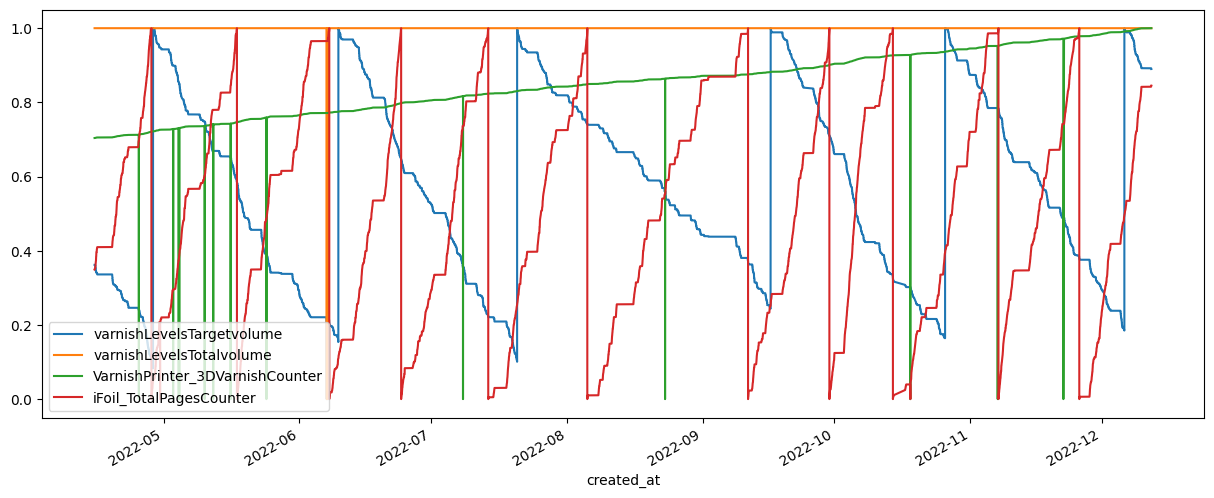

In [59]:
plot_timeseries(df_max_scaled)